# Photovoltaic power and solar radiation forecasting - Baseline
Base on the paper at https://sci-hub.st/https:/aip.scitation.org/doi/abs/10.1063/5.0014016

In [1]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime
from torchviz import make_dot
import torch
from torch import nn
from torchvision import transforms
from multiprocessing import cpu_count
from tqdm.notebook import tqdm_notebook
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

sns.set(style="ticks")

In [2]:
"""
Formatage du temps
"""
def to_time(debut):
    dt = time.time() - debut
    return round(dt / 60, 2)

## 1. Dataset

In [3]:
# datetime data
datetime_trainval= pd.DataFrame(np.load('dataset/datetime_trainval.npy', allow_pickle=True)[()], columns=['d_t'])
print(f"datetime_trainval.shape:   {datetime_trainval.shape}")
datetime_test    = pd.DataFrame(np.load('dataset/datetime_test.npy', allow_pickle=True)[()],columns=['d_t'])
print(f"datetime_test.shape    :   {datetime_test.shape}")

# pv log data
pv_log_trainval  = pd.DataFrame(np.load('dataset/pv_log_trainval.npy', allow_pickle=True)[()],columns=['pv_l'])
print(f"pv_log_trainval.shape  :   {pv_log_trainval.shape}")
pv_log_test      = pd.DataFrame(np.load('dataset/pv_log_test.npy', allow_pickle=True)[()],columns=['pv_l'])
print(f"pv_log_test.shape      :   {pv_log_test.shape}")

# sky images data
images_trainval  = np.load('dataset/images_trainval.npy', allow_pickle=True)[()]
print(f"images_trainval.shape  :   {images_trainval.shape}")
images_test      = np.load('dataset/images_test.npy', allow_pickle=True)[()]
print(f"images_test.shape      :   {images_test.shape}")

datetime_trainval.shape:   (92975, 1)
datetime_test.shape    :   (9910, 1)
pv_log_trainval.shape  :   (92975, 1)
pv_log_test.shape      :   (9910, 1)
images_trainval.shape  :   (92975, 64, 64, 3)
images_test.shape      :   (9910, 64, 64, 3)


In [4]:
# Extrating year, month, day, hour and minute from datetime data
datetime_trainval = datetime_trainval.assign(
    year=lambda datetime_trainval: datetime_trainval.d_t.map(lambda x: x.year),
    month=lambda datetime_trainval: datetime_trainval.d_t.map(lambda x: x.month),
    day=lambda datetime_trainval: datetime_trainval.d_t.map(lambda x: x.day),
    hour=lambda datetime_trainval: datetime_trainval.d_t.map(lambda x: x.hour),
    minute=lambda datetime_trainval: datetime_trainval.d_t.map(lambda x: x.minute)
)

df_tv_dtpvl = pd.concat([datetime_trainval,pv_log_trainval], axis=1)
df_tv_dtpvl.head()

,d_t,year,month,day,hour,minute,pv_l
0,2017-03-09 08:00:20,2017,3,9,8,0,6.205507
1,2017-03-09 08:01:20,2017,3,9,8,1,6.301439
2,2017-03-09 08:02:20,2017,3,9,8,2,6.456909
3,2017-03-09 08:03:20,2017,3,9,8,3,6.599264
4,2017-03-09 08:04:20,2017,3,9,8,4,6.719098


In [5]:
# Sample data for a single sunny day (2017-07-01)
df_2017_07_01 = df_tv_dtpvl[(df_tv_dtpvl.year==2017) & (df_tv_dtpvl.month==7) & (df_tv_dtpvl.day==1)]
print(f"df_2017_07_01.shape  : {df_2017_07_01.shape}")

# Sample data for a single cloudy day (2018-01-16)
df_2018_01_16 = df_tv_dtpvl[(df_tv_dtpvl.year==2018) & (df_tv_dtpvl.month==1) & (df_tv_dtpvl.day==16)]
print(f"df_2018_01_16.shape  : {df_2018_01_16.shape}")

df_2017_07_01.shape  : (600, 7)
df_2018_01_16.shape  : (508, 7)


## 2. Baseline: The end-to-end CNN model (SUNSET)

We'll implement a deep learning CNN model to correlate PV output to contemporaneous images of the sky (“now-cast”), that is, with the model, we'll be building a map between the input sky images and the corresponding PV output. rRMSE (relative root mean square error) will be use as quality evaluation metric.

An end-to-end CNN named Stanford University Neural Network for Solar Electricity Trend (SUNSET) developed by Sun et al. is used as the baseline. SUNSET takes sky images with dimension 64X64X3 as the input. The images first go through two Conv.–Pooling blocks, each including sequentially one convolutional layer, one batch normalization layer, and one pooling layer. The convolutional layer utilizes a filter size of 3X3, with a stride of 1 and same-value padding. The activation function used here is ReLU. 2X2 max pooling with strides of 2 is used in the pooling layer. The first Conv.-Pool block contains 24 filters, while the second contains 48. After the two Conv.–Pooling blocks, the processed input is flattened and passed through two fully connected layers, each containing 1024 neurons. ReLU is used as the activation function and dropout, with a 0.4 dropout rate, is performed to prevent over-fitting. A final regression step with linear weights is used to produce the predicted PV output.

<img src="SUNSET_architecture.png" alt="SUNSET architecture" style="width: 600px;"/>

Figure: SUNSET architecture adapted from https://sci-hub.st/https:/aip.scitation.org/doi/abs/10.1063/5.0014016

In [6]:
class DeepSunset(nn.Module):
    
    def __init__(self):
        
        super(DeepSunset, self).__init__()

        self.convolNet = nn.Sequential(
            # Conv #1
            nn.Conv2d(
                in_channels=3,
                out_channels=24,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            
            # Conv #2 
            nn.Conv2d(
                in_channels=24,
                out_channels=48,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        self.fulcon = nn.Sequential(
            # Fully Connected Layer 1
            nn.Linear(
                in_features=12288,
                out_features=1024,
                bias=True
            ),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            
            # Fully Connected Layer 2
            nn.Linear(
                in_features=1024,
                out_features=1024,
                bias=True
            ),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            
            # Regression Layer
            nn.Linear(
                in_features=1024,
                out_features=1,
                bias=True
            )
        )

    def forward(self, batch):
        result = self.convolNet(batch)
        result = result.view(batch.size(0), -1) # reshap pour obtenir une matrice 2 Dims
        result = self.fulcon(result)
        return result

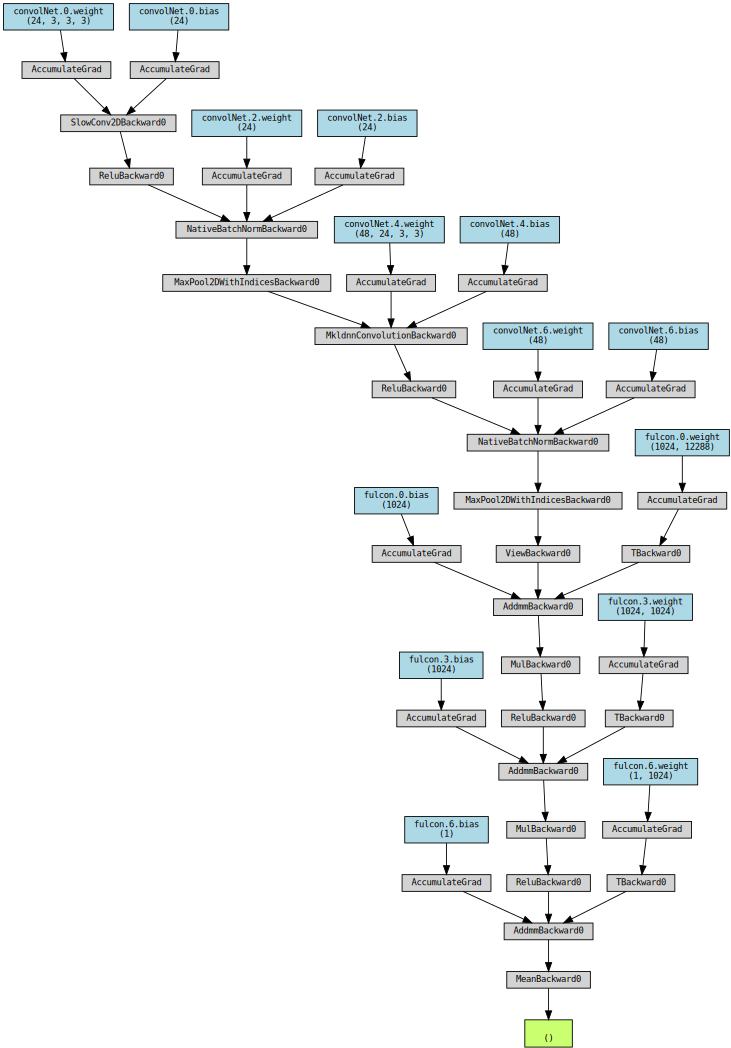

In [7]:
# Architecture verification
model = DeepSunset()
x = torch.zeros([1, 3, 64, 64])
y = model(x)

# Enregistrer le graphe das un fichier
make_dot(y.mean(), params=dict(model.named_parameters())).render("Sunset_torchviz", format="png")

# Afficher le graphe
make_dot(y.mean(), params=dict(model.named_parameters()))

#### Adding the .png file for visualization on github

<img src="Sunset_model-archit_deploy.png" alt="SUNSET model deployed" style="width: 800px;"/>
     

In [8]:
# Set show_attrs=True and show_saved=True to see what autograd saves for the backward pass.
# (Note: only available for pytorch >= 1.9.)
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [9]:
# The dataloader : (Batch_size,sky_img, pv_log)
pvl_trainval = np.load('dataset/pv_log_trainval.npy', allow_pickle=True)[()]

class MyDataset(Dataset):
    
    def __init__(self, imgs, pvls):
        
        self.imgs = imgs
        self.pvls = pvls
        

    def __getitem__(self, idx):
        imgsample = self.imgs[idx]
        pvlsample = self.pvls[idx]
        
        transform = transforms.Compose(
            [transforms.ToTensor()]
        )
        
        return transform(imgsample), torch.tensor(pvlsample)

    def __len__(self):
        return len(self.imgs)


dataset = MyDataset(images_trainval, pvl_trainval)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
training_set, validation_set = random_split(dataset, [train_size, val_size])
print(f'training samples : {len(training_set)}')
print(f'validati samples : {len(validation_set)}')
print(f'torch img shape  : {training_set[0][0].shape}')

training samples : 83677
validati samples : 9298
torch img shape  : torch.Size([3, 64, 64])


## Training

In [10]:
# For GPU suport   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepSunset().to(device)    
device

device(type='cpu')

In [11]:
# Training hyparameters
epochs = 20
lr = 3e-6
batch_size = 128

# The root mean squared error (RMSE) of PV output prediction 
# is used as the metric for evaluating the model performance
# There is no build-in rmse loss function in pytorch

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# The dataloader
train_loader = DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=cpu_count()-1,
    pin_memory=torch.cuda.is_available()
)

valid_loader = DataLoader(
    dataset=validation_set,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=cpu_count()-1,
    pin_memory=torch.cuda.is_available()
)

train_losses, valid_losses = [], []

print('\nTraining & validation ...\n')
for e in range(epochs):
    t0 = time.time()
    train_loss, valid_loss = 0, 0
    
    # train loop
    model.train()
    for images, pvl in train_loader:
        pvl = pvl.type(torch.FloatTensor)
        images, pvl = images.to(device), pvl.to(device)
        optimizer.zero_grad()
        pvl_hat = model(images)
        pvl_hat = torch.flatten(pvl_hat)
        loss = torch.sqrt(criterion(pvl_hat, pvl))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
          
    # valid loop
    model.eval()
    with torch.no_grad():
        for images, pvl in valid_loader:
            pvl = pvl.type(torch.FloatTensor)
            pvl_hat = model(images)
            pvl_hat = torch.flatten(pvl_hat)
            loss = torch.sqrt(criterion(pvl_hat, pvl))
            valid_loss += loss.item()

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)
     
    print(f"Epoch {e+1:02}/{epochs}: Train loss: {train_loss:0.3f} | Valid loss: {valid_loss:0.3f} | Duration: {to_time(t0)} mins")

print('Done!')

gc.collect()


Training & validation ...

Epoch 01/20: Train loss: 5.735 | Valid loss: 3.010 | Duration: 6.95 mins
Epoch 02/20: Train loss: 2.956 | Valid loss: 2.475 | Duration: 6.95 mins
Epoch 03/20: Train loss: 2.636 | Valid loss: 2.277 | Duration: 6.94 mins
Epoch 04/20: Train loss: 2.469 | Valid loss: 2.170 | Duration: 6.87 mins
Epoch 05/20: Train loss: 2.361 | Valid loss: 2.083 | Duration: 6.76 mins
Epoch 06/20: Train loss: 2.275 | Valid loss: 2.018 | Duration: 6.79 mins
Epoch 07/20: Train loss: 2.212 | Valid loss: 1.964 | Duration: 6.78 mins
Epoch 08/20: Train loss: 2.152 | Valid loss: 1.907 | Duration: 6.73 mins
Epoch 09/20: Train loss: 2.112 | Valid loss: 1.873 | Duration: 6.79 mins
Epoch 10/20: Train loss: 2.065 | Valid loss: 1.848 | Duration: 6.86 mins
Epoch 11/20: Train loss: 2.022 | Valid loss: 1.820 | Duration: 6.82 mins
Epoch 12/20: Train loss: 1.993 | Valid loss: 1.781 | Duration: 6.81 mins
Epoch 13/20: Train loss: 1.966 | Valid loss: 1.804 | Duration: 6.83 mins
Epoch 14/20: Train loss

0

## Learning Curves

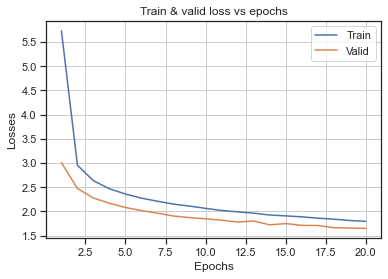

In [13]:
x = np.arange(1, epochs + 1)
plt.plot(x, train_losses, label='Train')
plt.plot(x, valid_losses, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & valid loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
    <b>Comment:</b>
    A good fitting, no overfitting nor underfitting with the used hyperparameters!
</div>

In [16]:
model_path = 'sunset_baselime_model.pth'
torch.save(model, model_path)

## Inferrering on test set

In [31]:
model=torch.load(model_path)
model.eval()

pvls_test = np.load('dataset/pv_log_test.npy', allow_pickle=True)[()]
imgs_test = np.load('dataset/images_test.npy', allow_pickle=True)[()]

test_transform = transforms.Compose([transforms.ToTensor()])

def predict_pvl(image):
    with torch.no_grad():
        image_tensor = test_transform(image).type(torch.FloatTensor)
        image_tensor = image_tensor.unsqueeze(0).to(device)
        pvl_hat = model(image_tensor)
        pvl_hat = torch.flatten(pvl_hat)
    return pvl_hat

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


pvls_hat = []
for img in tqdm_notebook(imgs_test):
    pvl_hat = predict_pvl(img)
    pvls_hat.append(torch.flatten(pvl_hat).item())

test_rmse = (rmse(pvls_hat, pvls_test))
print(f"Test set rmse: {test_rmse}")

  0%|          | 0/9910 [00:00<?, ?it/s]

Test set rmse: 2.2993118001383452
